In [1]:
import os, sys, imio, tifffile
from skimage.io import imread, imread_collection, concatenate_images
import skimage
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy import ndimage
from matplotlib import colors
from tqdm import tqdm
from brainglobe_utils.brainreg import transform
from brainglobe_atlasapi.bg_atlas import BrainGlobeAtlas

In [2]:
# include the raw image stack channels and the cellfinder output file in the NAME directory
NAME = 'SC037'
channel_signal_name = 'r'
channel_background_name = 'b'
network_nickname = 'bt14'
med_filter_iters = 3
atlas = BrainGlobeAtlas('allen_mouse_10um')

In [3]:
def open_binarised_coordinates(name):
    path = f'braintracer/fluorescence/binary_{name}.npy'
    assert os.path.isfile(path), f'Please provide binarised stack coordinates at {path}'
    coordinates = np.load(path)
    return coordinates

In [4]:
stack1 = imread_collection(f'{NAME}/{channel_signal_name}/*.tif')
stack2 = imread_collection(f'{NAME}/{channel_background_name}/*.tif')
len(stack1), len(stack2)

(3128, 3128)

In [5]:
foreg = imread(f'braintracer/downsampled_data/reg_{NAME}_{channel_signal_name}.tiff')
backg = imread(f'braintracer/downsampled_data/reg_{NAME}_{channel_background_name}.tiff')
foreg.shape, backg.shape

((1320, 800, 1140), (1320, 800, 1140))

In [6]:
def fit_model(model, y, x, name, ax=None):
    X = np.array(x).reshape(len(x),1)
    line_X = np.arange(min(x), max(x))[:, np.newaxis]
    model.fit(X, y)
    line_y = model.predict(line_X)
    try:
        if ax != None:
            ax.plot(line_X, line_y, color='r', linewidth=1, label=name)
        return model.coef_, model.intercept_
    except Exception:
        if ax != None:
            ax.plot(line_X, line_y, color='m', linewidth=1, label=name)
        return model.estimator_.coef_, model.estimator_.intercept_

def get_subtraction_coeffs(ax):
    ref_vals = backg.flatten()[::10_000] # every 1000 values of the array
    sig_vals = foreg.flatten()[::10_000] # same coordinates chosen from both image stacks

    if ax != None:
        ax.hist2d(ref_vals, sig_vals, bins=500, cmap=plt.cm.jet, norm=colors.LogNorm())
        ax.set_ylim(0,7000)
        ax.set_xlim(0,2000)

    ransac = linear_model.RANSACRegressor(max_trials=30)
    m, c = fit_model(ransac, sig_vals, ref_vals, 'RANSAC', ax=ax)
    m = m[0] # extract from array
    return m, c

Subtraction parameters are: m=0.20902987371542753, c=0.1595251322536284


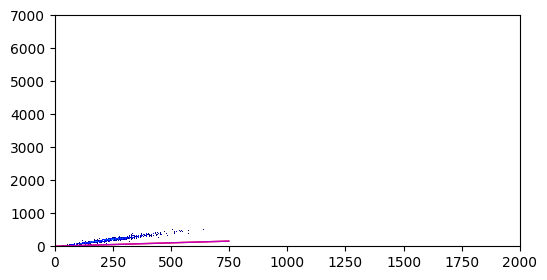

In [7]:
f, ax = plt.subplots(figsize=(6,3))
m, c = get_subtraction_coeffs(ax)
#plt.savefig(f'fit.png', dpi=600, bbox_inches='tight')
print(f'Subtraction parameters are: m={m}, c={c}')

# Manually Find Best Threshold

In [8]:
slice_to_analyse = 810

In [9]:
this_slice = stack1[slice_to_analyse]
bg_slice = stack2[slice_to_analyse]
subtracted_slice = this_slice - ((bg_slice * m) + c)

pixel_sample = subtracted_slice.flatten()

In [10]:
sorted_pixels = np.sort(pixel_sample)

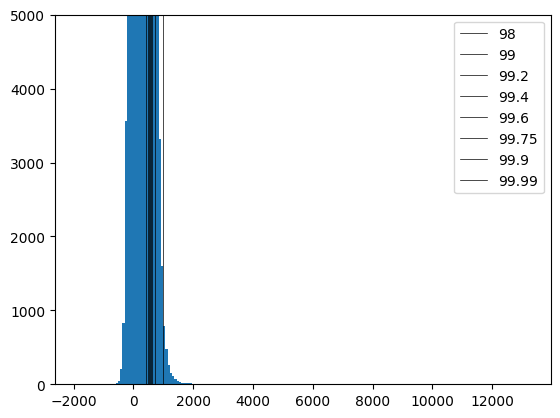

In [11]:
plt.hist(pixel_sample, bins=200);
plt.ylim(0,5000)

percentiles = [98, 99, 99.2, 99.4, 99.6, 99.75, 99.9, 99.99]
for p in percentiles:
    x_for_p = np.percentile(sorted_pixels, p)
    plt.axvline(x=x_for_p, c='k', linewidth=0.5, label=f'{p}')
plt.legend()

In [14]:
percentile = 99.9
binary_threshold = np.percentile(sorted_pixels, percentile)

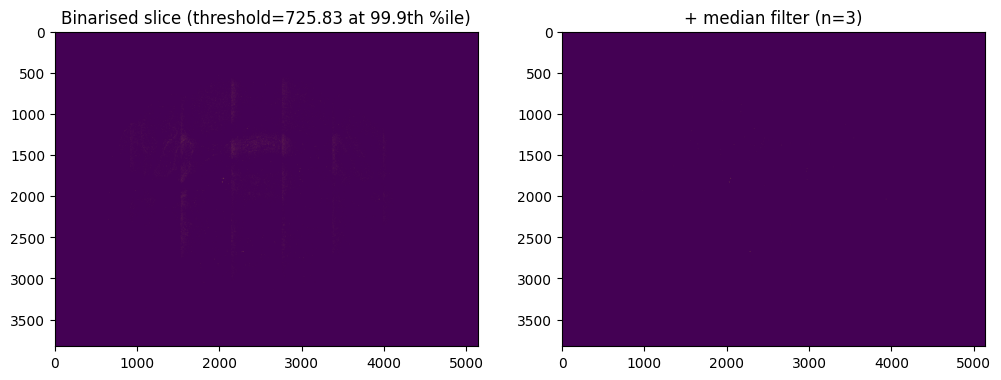

In [15]:
binary_image = np.where(subtracted_slice > binary_threshold, 1, 0)
mfl_im = ndimage.median_filter(binary_image, med_filter_iters)

f, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].imshow(binary_image)
axs[0].set_title(f'Binarised slice (threshold={binary_threshold:.2f} at {percentile}th %ile)')
axs[1].imshow(mfl_im)
axs[1].set_title(f'+ median filter (n={med_filter_iters})');
plt.savefig(f"threshold_selection_{NAME}_slice={slice_to_analyse}.png", dpi=600, format="png")

## Efficient coord calc

In [16]:
all_coords = []

for i in tqdm(range(len(stack1))):
    subtracted_im = stack1[i] - ((stack2[i] * m) + c)
    bin_im = np.where(subtracted_im > binary_threshold, 1, 0)
    mfl_im = ndimage.median_filter(bin_im, med_filter_iters)
    x_idxs, y_idxs = np.where(mfl_im == 1)
    if len(x_idxs) > 0:
        x_idxs = x_idxs.astype(np.uint16)
        y_idxs = y_idxs.astype(np.uint16)
        z_idxs = np.full_like(x_idxs, fill_value=i, dtype=np.uint16)
        coords = np.stack((x_idxs, y_idxs, z_idxs), axis=1)
        all_coords.append(coords)

if all_coords:
    all_coords = np.concatenate(all_coords, axis=0)
else:
    all_coords = np.zeros((0, 3), dtype=np.uint16)

100%|███████████████████████████████████████████████████████████████████████████| 3128/3128 [52:40<00:00,  1.01s/it]


## Save

In [17]:
dir_path = 'braintracer/fluorescence/'
if not os.path.isdir(dir_path):
    os.makedirs(dir_path)
dest = dir_path + f'binary_vectorised_{NAME}_{channel_signal_name}'
np.save(dest, all_coords)

## Load

In [18]:
try:
    coordinates_yxz = open_binarised_coordinates(f'vectorised_{NAME}_{channel_signal_name}') # values saved in array as yxz rather than xyz
    coordinates = np.flip(coordinates_yxz, axis=1) # z, x, y
except Exception as e:
    coordinates_yxz = open_binarised_coordinates(f'{NAME}_{channel_signal_name}') # old non-vectorised format
    coordinates = np.flip(coordinates_yxz.T, axis=1) # z, x, y

## Transforming coordinates to downsampled space

In [19]:
signal_planes = f'{NAME}/{channel_signal_name}'
source_shape = tuple(imio.get_size_image_from_file_paths(signal_planes).values())
source_shape = (source_shape[2], source_shape[1], source_shape[0]) # z, y, x   # here z is shorter than x and y because resolution is 5 um
# should be downsampled_channel_0 but same resolution anyway?
dest_shape = imread(f'{NAME}/cellfinder_{channel_signal_name}_{network_nickname}/registration/downsampled_channel_0.tiff').shape # z, y, x
scalars = tuple(x / source_shape[i] for i, x in enumerate(dest_shape)) # (dest_shape / source_shape) as tuple
print(f'Source shape: {source_shape}, Destination shape: {dest_shape}, Calculated scalars: {scalars}') # z, y, x

Source shape: (3128, 3825, 5137), Destination shape: (1564, 765, 1027), Calculated scalars: (0.5, 0.2, 0.19992213354097724)


In [20]:
coordinates[:,0] = np.round(coordinates[:,0] * scalars[0]) # downsample coordinates
coordinates[:,1] = np.round(coordinates[:,1] * scalars[1])
coordinates[:,2] = np.round(coordinates[:,2] * scalars[2])
coordinates[:,0] = dest_shape[0] - coordinates[:,0] # flip the z axis because that's what brainreg does to get psr
downsampled_points = coordinates # rename var ____ z, x, y
np.max(downsampled_points, axis=0)

array([1564, 1025,  755], dtype=uint16)

## Transforming coordinates to atlas space

In [21]:
def get_deformation_field_path(num):
    return f'{NAME}/cellfinder_{channel_signal_name}_{network_nickname}/registration/deformation_field_{num}.tiff'
deformation_field_paths = [get_deformation_field_path(0), get_deformation_field_path(1), get_deformation_field_path(2)]
# z, y, x because psr orientation

In [22]:
# swap the x and y value of each coordinate to match the deformation fields
downsampled_points[:, 1], downsampled_points[:, 2] = downsampled_points[:, 2], downsampled_points[:, 1].copy()

In [23]:
# remove the last slice of coordinates in each axis because not in the deformation matrices
downsampled_points = downsampled_points[downsampled_points[:,0]<dest_shape[0]]
downsampled_points = downsampled_points[downsampled_points[:,1]<dest_shape[1]]
downsampled_points = downsampled_points[downsampled_points[:,2]<dest_shape[2]]

In [24]:
transformed_cells = transform.transform_points_from_downsampled_to_atlas_space( # z, y, x coordinates and 0, 1, 2 deformation fields
            downsampled_points,
            atlas,
            deformation_field_paths)

In [25]:
# trim the transformed coordinates within the shape of the atlas
tc = transformed_cells[0]
tc = tc[np.logical_and.reduce((tc[:,0] < atlas.shape[0], tc[:,1] < atlas.shape[1], tc[:,2] < atlas.shape[2]))]
np.max(tc, axis=0) # z, y, x

array([1319,  799, 1119])

## Save coordinates for use in braintracer downstream functions

In [26]:
dir_path = 'braintracer/fluorescence/'
if not os.path.isdir(dir_path):
    os.makedirs(dir_path)
dest = dir_path + f'binary_registered_{NAME}_{channel_signal_name}'
np.save(dest, tc)

## Save version without a bulk of labelling from injection site to save memory

In [27]:
from braintracer.braintracer.analysis import vectorised_get_area_index
from braintracer.braintracer.analysis import children_from
tc = open_binarised_coordinates(f'registered_{NAME}_{channel_signal_name}') # use if already saved using the function above

In [28]:
parent, children = children_from(528, depth=0)
areas = [parent] + children

In [29]:
z_coords, y_coords, x_coords = tc[:, 0], tc[:, 1], tc[:, 2]
area_indices = vectorised_get_area_index(z_coords, y_coords, x_coords)
mask = ~np.isin(area_indices, areas)  # True for entries NOT in areas
tc_filtered = tc[mask]

In [30]:
dir_path = 'braintracer/fluorescence/'
if not os.path.isdir(dir_path):
    os.makedirs(dir_path)
dest = dir_path + f'binary_registered_skimmed_{NAME}_{channel_signal_name}'
np.save(dest, tc_filtered)

## Email

In [ ]:
def send_email_notification():
    import smtplib
    content = ("Processing complete.")
    mail = smtplib.SMTP('smtp.gmail.com', 587)
    mail.ehlo()
    mail.starttls()
    mail.login('scloth.dev@gmail.com', 'qmmv tuiw jymk vypp')
    mail.sendmail('scloth.dev@gmail.com', 'sam.clth@gmail.com', content) 
    mail.close()

In [ ]:
send_email_notification()